In [ ]:
#USE PYTHON 3.10.15 FOR TENSORFLOW AND CUDA/CUDNN COMPATIBILITY
#IF ON WINDOWS, INSTALL TENSORFLOW 2.10 CUDA 11.2 and cuDNN 8.1 FOR GPU SUPPORT
#(YOU ALSO NEED VISUAL STUDIO 2019)

In [ ]:
conda install numpy pandas matplotlib seaborn
!pip install scikit-learn

#NIBABEL IS A LIBRARY TO OPEN, READ AND MANIPULATE .nii or .nii.gz MRI files
!pip install nilearn
!pip install nibabel

#Tensorflow 2.10 installed through Anaconda Prompt

In [2]:
import os
import shutil
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
import schizophrenia_prediction_functions as spf
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, GlobalAveragePooling3D, Dense, Dropout

In [3]:
pd.set_option("display.max_rows" , 500)
pd.set_option("display.max_columns" , 50)

## IMPORT AND FORMAT ALL PATIENT METADATA

In [4]:

df_cobre = pd.read_csv("COBRE_phenotypic_data.csv")
df_cobre.rename(columns={"Unnamed: 0":"patient_id"}).head()
df_cobre.rename(columns={"Unnamed: 0":"patient_id"}, inplace=True)
df_cobre_schiz = df_cobre[df_cobre["Diagnosis"].isnull() == False]
df_cobre_control = df_cobre[df_cobre["Diagnosis"].isnull() == True]
df_cobre_schiz.drop(index=[146,147], inplace = True)
df_cobre_schiz = df_cobre_schiz[df_cobre_schiz["Subject Type"] != "Control"]
spf.recast(df_cobre_schiz, "Current Age")

C:\Users\JimiH\AppData\Local\Temp\ipykernel_3360\3681652215.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cobre_schiz.drop(index=[146,147], inplace = True)


,patient_id,Current Age,Gender,Handedness,Subject Type,Diagnosis
2,40046,18,Male,Left,Patient,295.70 depressed type
3,40002,19,Male,Right,Patient,295.3
4,40117,19,Male,Right,Patient,295.3
5,40145,19,Male,Right,Patient,295.6
7,40000,20,Female,Right,Patient,295.9
8,40029,20,Male,Right,Patient,295.6
9,40133,20,Male,Right,Patient,295.3
11,40021,21,Female,Right,Patient,295.3
12,40137,21,Male,Left,Patient,295.2
17,40085,22,Male,Right,Patient,295.3


In [5]:
df_on_ds004302 = pd.read_csv("on_ds004302_participants.tsv", sep='\t' )
df_on_ds004302_schiz = df_on_ds004302[df_on_ds004302["group"] != "HC"]
df_on_ds004302_control = df_on_ds004302[df_on_ds004302["group"] == "HC"]

In [6]:
df_on_ds004837 = pd.read_csv("on_ds004837_participants.csv")
df_on_ds004837_control = df_on_ds004837[df_on_ds004837["SUBTYPE2"] == "HC"]
df_on_ds004837['SUBTYPE2'] = df_on_ds004837['SUBTYPE2'].str.strip()
df_on_ds004837_schiz = df_on_ds004837[df_on_ds004837["SUBTYPE2"] == "FESZ"]

In [7]:
df_on_ds005073 = pd.read_csv("on_ds005073_diagnosed_participants.tsv", sep = '\t')
df_on_ds005073.drop(index=range(31,len(df_on_ds005073)), inplace=True)
df_on_ds005073_schiz = df_on_ds005073[df_on_ds005073["groupID"] == "2"]

In [8]:
df_on_ds005073_control = pd.read_csv("on_ds005073_control_participants.tsv", sep = '\t')
df_on_ds004873_control = pd.read_csv("on_ds_004873_participants.tsv", sep="\t")

In [9]:
#select patients > 30 for control group to be more in line with schizophrenic patients
df_on_ds004873_control_slct = df_on_ds004873_control[df_on_ds004873_control["age"]>30]

In [10]:
#Scans of schizophrenic patients
#df_cobre_schiz
#df_on_ds004302_schiz (SKULL STRIPPED!)
#df_on_ds004837_schiz
#df_on_ds005073_schiz

#Scans of healthy control patients
#df_cobre_control
#df_on_ds004302_control (SKULL STRIPPED)
#df_on_ds004837_control
#df_on_ds005073_control
#df_on_ds005266_control
#df_on_ds004873_control

In [12]:
#Formatting all metadata to a standard format

df_cobre_schiz_std = df_cobre_schiz.drop(columns=["Subject Type","Diagnosis"])
df_cobre_schiz_std.rename(columns={"Current Age":"age","Gender":"sex","Handedness":"handedness"}, inplace=True)
df_cobre_schiz_std["study"] = "cobre"

df_cobre_control_std = df_cobre_control.drop(columns=["Subject Type","Diagnosis"])
df_cobre_control_std.rename(columns={"Current Age":"age","Gender":"sex","Handedness":"handedness"}, inplace=True)
df_cobre_control_std["study"] = "cobre"
spf.recast(df_cobre_control_std, "age")

df_on_ds004302_schiz_std = df_on_ds004302_schiz.drop(columns=["iq","group","psyrats"])
df_on_ds004302_schiz_std.rename(columns={"participant_id":"patient_id"}, inplace=True)
df_on_ds004302_schiz_std["study"] = "on_ds004302"
df_on_ds004302_schiz_std["handedness"] = "R"
df_on_ds004302_schiz_std = df_on_ds004302_schiz_std[["patient_id","age","sex","handedness","study"]]

df_on_ds004302_control_std = df_on_ds004302_control.drop(columns=["iq","group","psyrats"])
df_on_ds004302_control_std.rename(columns={"participant_id":"patient_id"}, inplace=True)
df_on_ds004302_control_std["study"] = "on_ds004302"
df_on_ds004302_control_std["handedness"] = "R"
df_on_ds004302_control_std = df_on_ds004302_control_std[["patient_id","age","sex","handedness","study"]]

df_on_ds004837_schiz_std = df_on_ds004837_schiz.filter(items=["RECID", "SEX", "AGE","HAND"])
df_on_ds004837_schiz_std.rename(columns={"RECID":"patient_id", "SEX":"sex", "AGE":"age","HAND":"handedness"}, inplace=True)
df_on_ds004837_schiz_std["study"] = "on_ds004837"
df_on_ds004837_schiz_std = df_on_ds004837_schiz_std[["patient_id","age","sex","handedness","study"]]

df_on_ds004837_control_std = df_on_ds004837_control.filter(items=["RECID", "SEX", "AGE","HAND"])
df_on_ds004837_control_std.rename(columns={"RECID":"patient_id", "SEX":"sex", "AGE":"age","HAND":"handedness"}, inplace=True)
df_on_ds004837_control_std["study"] = "on_ds004837"
df_on_ds004837_control_std = df_on_ds004837_control_std[["patient_id","age","sex","handedness","study"]]

df_on_ds005073_schiz_std = df_on_ds005073_schiz.filter(items=["participant_id", "gender", "age","handedness"])
df_on_ds005073_schiz_std.rename(columns={"participant_id":"patient_id", "gender":"sex"}, inplace=True)
df_on_ds005073_schiz_std["study"] = "on_ds005073"
df_on_ds005073_schiz_std = df_on_ds005073_schiz_std[["patient_id","age","sex","handedness","study"]]

df_on_ds005073_control_std = df_on_ds005073_control.filter(items=["participant_id", "Gender", "Age","Handedness"])
df_on_ds005073_control_std.rename(columns={"participant_id":"patient_id", "Gender":"sex", "Age":"age","Handedness":"handedness"}, inplace=True)
df_on_ds005073_control_std["study"] = "on_ds005073"
df_on_ds005073_control_std = df_on_ds005073_control_std[["patient_id","age","sex","handedness","study"]]

df_on_ds004873_control_std = df_on_ds004873_control_slct.filter(items=["participant_id", "sex", "age"])
df_on_ds004873_control_std.rename(columns={"participant_id":"patient_id"}, inplace=True)
df_on_ds004873_control_std["study"] = "on_ds004873"
df_on_ds004873_control_std["handedness"] = "R"
df_on_ds004873_control_std = df_on_ds004873_control_std[["patient_id","age","sex","handedness","study"]]
df_on_ds004873_control_std.dtypes

patient_id    object
age            int64
sex           object
handedness    object
study         object
dtype: object

In [13]:
#Creating the comprehensive schizophrenic and control dataframes
metadata_schiz = pd.concat([df_cobre_schiz_std,df_on_ds004302_schiz_std,df_on_ds004837_schiz_std,df_on_ds005073_schiz_std], axis=0, join="outer", ignore_index=True)

metadata_control = pd.concat([df_cobre_control_std,df_on_ds004302_control_std,df_on_ds004837_control_std, df_on_ds005073_control_std, df_on_ds004873_control_std], axis=0, join="outer", ignore_index=True)

In [14]:
#Further formatting
replacements = {'Male':'M','male': 'M',"m":"M","f":"F",'Female':'F','female':'F','Right':'R', 'Left':'L'}

metadata_schiz.replace(replacements, inplace=True)

metadata_control.replace(replacements, inplace=True)

spf.recast(metadata_schiz, 'age')
spf.recast(metadata_control, 'age')

metadata_schiz['patient_id'] = metadata_schiz['patient_id'].astype(str)
metadata_control['patient_id'] = metadata_control['patient_id'].astype(str)

In [15]:
metadata_schiz

,patient_id,age,sex,handedness,study
0,40046,18,M,L,cobre
1,40002,19,M,R,cobre
2,40117,19,M,R,cobre
3,40145,19,M,R,cobre
4,40000,20,F,R,cobre
5,40029,20,M,R,cobre
6,40133,20,M,R,cobre
7,40021,21,F,R,cobre
8,40137,21,M,L,cobre
9,40085,22,M,R,cobre


In [16]:
metadata_control

,patient_id,age,sex,handedness,study
0,40061,18,M,R,cobre
1,40090,18,F,R,cobre
2,40113,20,M,R,cobre
3,40121,21,F,R,cobre
4,40020,22,M,R,cobre
5,40052,22,F,R,cobre
6,40065,22,M,R,cobre
7,40128,22,M,R,cobre
8,40051,23,M,R,cobre
9,40114,23,M,R,cobre


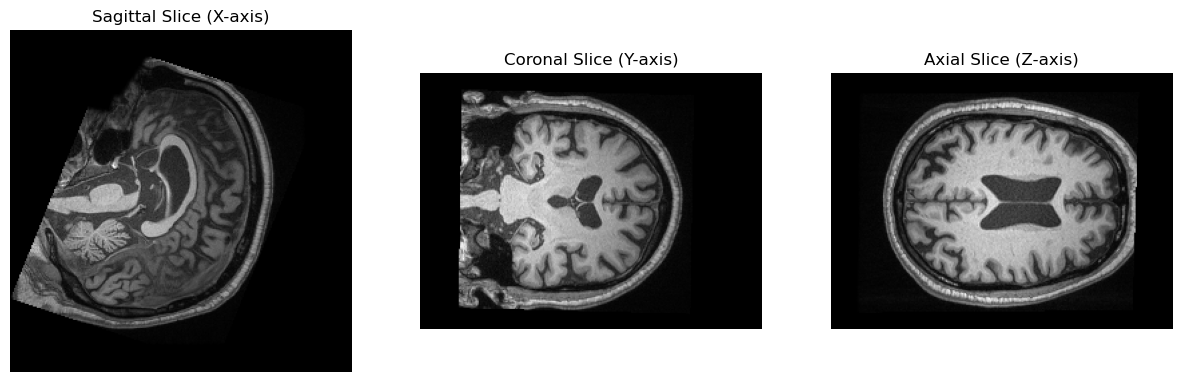

In [19]:
#INSPECTING THE MIDDLE SLICES OF EVERY AXIS FOR AN MRI SCAN
#CHANGE THE 'path' VARIABLE TO ANY FILEPATH AT WILL FOR ANY GIVEN MRI SCAN OF INTEREST (.nii or .nii.gz FILES)

path = "40044_mprage.nii.gz"
img = nib.load(path)
data = img.get_fdata()

slice_x = data.shape[0]//2 #Sagittal slice (X-axis)
slice_y = data.shape[1]//2 #Coronal slice (Y-axis)
slice_z = data.shape[2]//2 #Transversal (axial?) slice (Z-Axis)

fig, axes = plt.subplots(1, 3, figsize = (15,5))

#Sagittal
axes[0].imshow(data[slice_x, :, :], cmap='gray', origin="lower")
axes[0].set_title("Sagittal Slice (X-axis)")
axes[0].axis('off')

# Coronal
axes[1].imshow(data[:, slice_y, :], cmap='gray', origin="lower")
axes[1].set_title('Coronal Slice (Y-axis)')
axes[1].axis('off')

# Axial
axes[2].imshow(data[:, :, slice_z], cmap='gray', origin="lower")
axes[2].set_title('Axial Slice (Z-axis)')
axes[2].axis('off')

plt.show()

In [20]:
#GET THE NUMBER OF SLICES FOR EVERY AXIS
img.shape

(192, 256, 256)

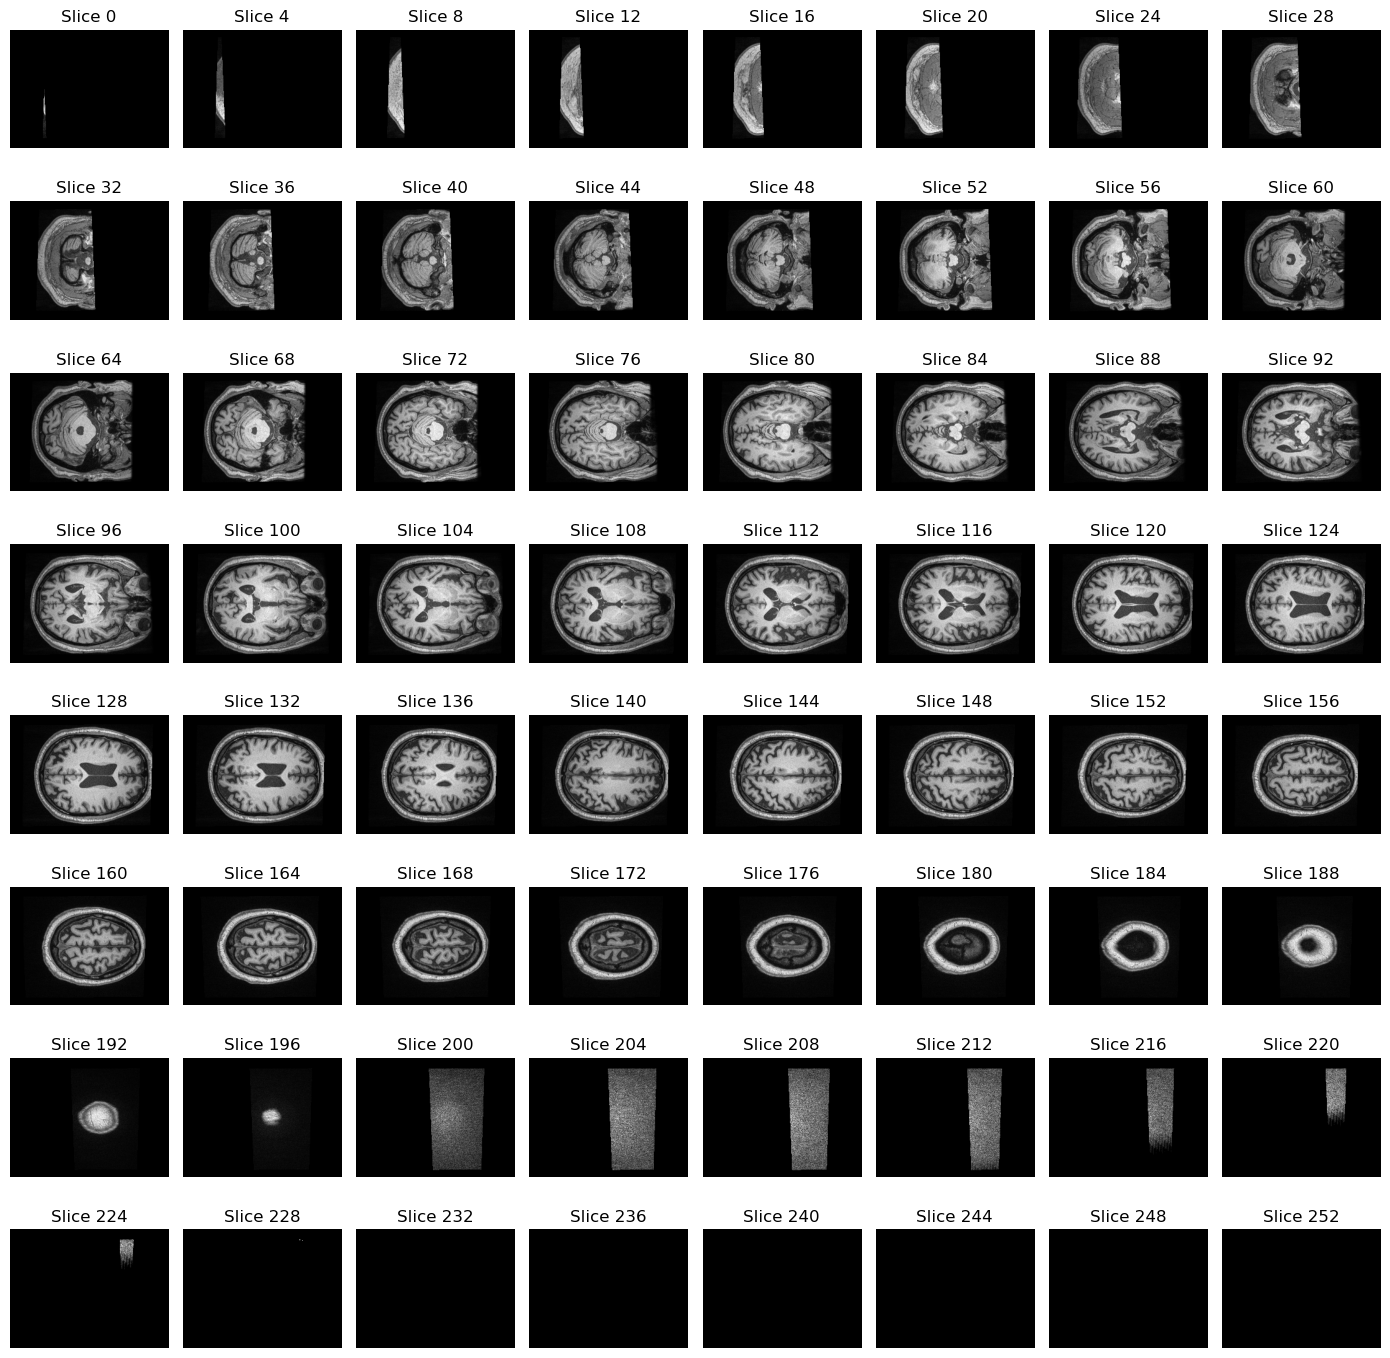

In [21]:
#DISPLAY ALL SLICES OF A SPECIFIED AXIS IN A SPECIFIED STEP RANGE IN A GRID

# Set up figure with appropriate grid size
num_slices = 256
step = 4
slices = range(0, num_slices, step)


grid_size = (8, 8)
fig, axes = plt.subplots(*grid_size, figsize=(14, 14))


for i, slice_z in enumerate(slices):
    row = i // grid_size[1]
    col = i % grid_size[1]
    axes[row, col].imshow(data[:, :, slice_z], cmap='gray', origin='lower')
    axes[row, col].set_title(f'Slice {slice_z}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

## BASIC EDA

In [ ]:
sns.histplot(metadata_schiz['age'], kde=True, color='blue')

In [ ]:
sns.histplot(metadata_control['age'], kde=True, color='blue')

## ADDING FILENAMES TO THE DATAFRAMES

In [ ]:
metadata_schiz_fn = metadata_schiz.copy()
metadata_control_fn = metadata_control.copy()

In [ ]:
metadata_schiz_fn.loc[metadata_schiz_fn['study'] == 'cobre', 'filename'] = metadata_schiz_fn['patient_id'] + '_mprage.nii.gz'
metadata_schiz_fn.loc[metadata_schiz_fn['study'] == 'on_ds004302', 'filename'] = metadata_schiz_fn['patient_id'] + '_T1w.nii.gz'
metadata_schiz_fn.loc[metadata_schiz_fn['study'] == 'on_ds004837', 'filename'] = 'sub-' + metadata_schiz_fn['patient_id'] + 'A_ses-0001_T1w.nii.gz'
metadata_schiz_fn.loc[metadata_schiz_fn['study'] == 'on_ds005073', 'filename'] = metadata_schiz_fn['patient_id'] + '_rec-2_T1w.nii.gz'

In [ ]:
metadata_control_fn.loc[metadata_control_fn['study'] == 'cobre', 'filename'] = metadata_control_fn['patient_id'] + '_mprage.nii.gz'
metadata_control_fn.loc[metadata_control_fn['study'] == 'on_ds004302', 'filename'] = metadata_control_fn['patient_id'] + '_T1w.nii.gz'
metadata_control_fn.loc[metadata_control_fn['study'] == 'on_ds004837', 'filename'] = 'sub-' + metadata_control_fn['patient_id'] + 'A_ses-0001_T1w.nii.gz'
metadata_control_fn.loc[metadata_control_fn['study'] == 'on_ds005073', 'filename'] = metadata_control_fn['patient_id'] + '_rec-2_T1w.nii.gz'
metadata_control_fn.loc[metadata_control_fn['study'] == 'on_ds004873', 'filename'] = metadata_control_fn['patient_id'] + '_T1w.nii.gz'

In [ ]:
metadata_control_fn.shape

In [ ]:
metadata_schiz_fn.shape

## MOVING AND FORMATTING RELEVANT MRI SCANS

In [ ]:
directory = r"C:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\ds004302"

spf.delete_subfolder(directory)

In [ ]:
directory = r"C:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\ds005073"

spf.delete_subfolder(directory)

In [ ]:
directory = r"C:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\ds004837"

spf.delete_sub_subfolder(directory)

In [ ]:
directory = r"C:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\COBRE"

spf.rename_subfolder(directory)

In [ ]:
directory = r"C:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\COBRE"

spf.delete_sub_subfolder2(directory)

In [ ]:
directory = r"C:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\COBRE"

spf.move_file(directory)

In [ ]:
spf.delete_subfolder2(directory)
spf.rename_files(directory)

In [ ]:
directory = r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\cobre"

spf.move_files_to_parent_directory(directory)

In [ ]:
directory = r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\on_ds004302"

spf.move_files_to_parent_directory_2lvls(directory)

In [ ]:
directory = r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\on_ds004837"

spf.move_files_from_deepest_subdirectories(directory)

In [ ]:
directory = r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\UNINCORPORATED HC\OpenNeuro ds005266 HC"

spf.delete_subfolder(directory)

In [ ]:
def move_file_schiz (directory):
    """
    moves all files in the metadata_schiz_fn dataframe
    """
    schiz_folder = os.path.join(directory, "schiz")
    os.makedirs(schiz_folder, exist_ok=True)

    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        if os.path.isfile(item_path) and item in metadata_schiz_fn["filename"].values:
                new_path = os.path.join(schiz_folder, item)
                try:
                    shutil.move(item_path, new_path)
                    print(f"Moved:{item_path} to {new_path}")
                except Exception as e:
                    print(f"Error moving {item_path}: {e}")

In [ ]:
def move_file_control (directory):
    """
    moves all files in the metadata_control_fn dataframe
    """
    control_folder = os.path.join(directory, "control")
    os.makedirs(control_folder, exist_ok=True)

    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        if os.path.isfile(item_path) and item in metadata_control_fn["filename"].values:
                new_path = os.path.join(control_folder, item)
                try:
                    shutil.move(item_path, new_path)
                    print(f"Moved:{item_path} to {new_path}")
                except Exception as e:
                    print(f"Error moving {item_path}: {e}")

In [ ]:
directory = r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\cobre"
spf.move_file_control(directory)
spf.move_file_schiz(directory)

In [ ]:
directory = r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\on_ds004302"

spf.move_file_control(directory)
spf.move_file_schiz(directory)

In [ ]:
directory = r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\on_ds004837"
spf.move_file_control(directory)
spf.move_file_schiz(directory)

In [ ]:
#FLIP AND REORDER AXES OF STUDY ON_DS004873

Directory containing the MRI files
input_dir = r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\on_ds004873\control"
output_dir = r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\on_ds004873\control\axes_transposed_flipped"
os.makedirs(output_dir, exist_ok=True)

# Process each .nii file in the input directory
for filename in os.listdir(input_dir):
    if filename.endswith(".nii.gz"):
        # Load the MRI scan
        input_path = os.path.join(input_dir, filename)
        img = nib.load(input_path)
        data = img.get_fdata()
        
        # Set the current order and the target order for standardization
        current_order = (1, 2, 0)  # Assuming current order is (coronal, axial, sagittal)
        target_order = (0, 1, 2)  # Desired order (sagittal, coronal, axial)
        
        # Apply reordering and flipping
        transformed_data = spf.reorder_and_flip_axes(data, current_order, target_order)
        
        # Save the transformed image
        output_path = os.path.join(output_dir, filename)
        transformed_img = nib.Nifti1Image(transformed_data, img.affine, img.header)
        nib.save(transformed_img, output_path)
        print(f"Transformed and saved: {output_path}")

## APPLYING FSL SKULL STRIPPING TOOL BET

Download the FSL Library from https://fsl.fmrib.ox.ac.uk/fsl/docs/#/ and follow the instructions. If you are using Windows you should probably install Ubuntu WSL to properly use the FSL tools, since they are optimized for Linux. Use bash scripts to execute BET commands (they are contained as .sh files in the repository).

BET removes any non-brain tissue from the MRI scan.

In [ ]:
# INSPECT SCANS AFTER APPLYING SKULL STRIPPING.
# DISPLAYS THE FIRST SCAN OUT OF EVERY CONTROL AND SCHIZOPHRENIC FOLDER OF EVERY STUDY.

directories = [
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\cobre\control",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\cobre\schiz",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\on_ds004302\control",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\on_ds004302\schiz",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\on_ds004837\control",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\on_ds004837\schiz",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\on_ds005073\control",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\on_ds005073\schiz",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\on_ds004873\control"

]

# List to hold file paths of the first .nii file found in each directory
nii_files = []

# Find the first .nii file in each directory
for directory in directories:
    for file in os.listdir(directory):
        if file.endswith(".nii.gz"):
            nii_files.append(os.path.join(directory, file))
            break  # Stop after the first .nii file in the directory

# Set up the plot grid based on the number of .nii files
num_files = len(nii_files)
fig, axes = plt.subplots(num_files, 3, figsize=(15, 5 * num_files))

# Display slices from each .nii file
for i, path in enumerate(nii_files):
    img = nib.load(path)
    data = img.get_fdata()
    
    # Get central slices
    slice_x = data.shape[0] // 2  # Sagittal slice (X-axis)
    slice_y = data.shape[1] // 2  # Coronal slice (Y-axis)
    slice_z = data.shape[2] // 2  # Axial slice (Z-axis)

    # Display Sagittal slice
    axes[i, 0].imshow(data[slice_x, :, :], cmap='gray', origin="lower")
    axes[i, 0].set_title(f"Sagittal Slice (X-axis) - {os.path.basename(path)}")
    axes[i, 0].axis('off')

    # Display Coronal slice
    axes[i, 1].imshow(data[:, slice_y, :], cmap='gray', origin="lower")
    axes[i, 1].set_title(f"Coronal Slice (Y-axis) - {os.path.basename(path)}")
    axes[i, 1].axis('off')

    # Display Axial slice
    axes[i, 2].imshow(data[:, :, slice_z], cmap='gray', origin="lower")
    axes[i, 2].set_title(f"Axial Slice (Z-axis) - {os.path.basename(path)}")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.savefig("skull_stripped.png", dpi=300)
plt.show()


In [ ]:
directory = r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped"
spf.z_score_normalize(directory)

In [ ]:
# INSPECT SCANS AFTER APPLYING Z-SCORE NORMALIZATION.
# DISPLAYS THE FIRST SCAN OUT OF EVERY CONTROL AND SCHIZOPHRENIC FOLDER OF EVERY STUDY.

# List of directories to search for the first .nii file
directories = [
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm\cobre\control",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm\cobre\schiz",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm\on_ds004302\control",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm\on_ds004302\schiz",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm\on_ds004837\control",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm\on_ds004837\schiz",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm\on_ds005073\control",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm\on_ds005073\schiz",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm\on_ds004873\control"

    # Add more directories as needed
]

# List to hold file paths of the first .nii file found in each directory
nii_files = []

# Find the first .nii file in each directory
for directory in directories:
    for file in os.listdir(directory):
        if file.endswith(".nii.gz"):
            nii_files.append(os.path.join(directory, file))
            break  # Stop after the first .nii file in the directory

# Set up the plot grid based on the number of .nii files
num_files = len(nii_files)
fig, axes = plt.subplots(num_files, 3, figsize=(15, 5 * num_files))

# Display slices from each .nii file
for i, path in enumerate(nii_files):
    img = nib.load(path)
    data = img.get_fdata()
    
    # Get central slices
    slice_x = data.shape[0] // 2  # Sagittal slice (X-axis)
    slice_y = data.shape[1] // 2  # Coronal slice (Y-axis)
    slice_z = data.shape[2] // 2  # Axial slice (Z-axis)

    # Display Sagittal slice
    axes[i, 0].imshow(data[slice_x, :, :], cmap='gray', origin="lower")
    axes[i, 0].set_title(f"Sagittal Slice (X-axis) - {os.path.basename(path)}")
    axes[i, 0].axis('off')

    # Display Coronal slice
    axes[i, 1].imshow(data[:, slice_y, :], cmap='gray', origin="lower")
    axes[i, 1].set_title(f"Coronal Slice (Y-axis) - {os.path.basename(path)}")
    axes[i, 1].axis('off')

    # Display Axial slice
    axes[i, 2].imshow(data[:, :, slice_z], cmap='gray', origin="lower")
    axes[i, 2].set_title(f"Axial Slice (Z-axis) - {os.path.basename(path)}")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.savefig("skull_stripped.png", dpi=300)
plt.show()

## APPLYING FSL ALIGNMENT TOOL FLIRT

Download the FSL Library from https://fsl.fmrib.ox.ac.uk/fsl/docs/#/ and follow the instructions. If you are using Windows you should probably install Ubuntu WSL to properly use the FSL tools, since they are optimized for Linux. Use bash scripts to execute FLIRT commands (they are contained as .sh files in the repository).

FLIRT aligns every scan using a standardized high-quality MRI as a template.

In [ ]:
# INSPECT THE SCANS AFTER APPLYING FLIRT.
# DISPLAYS THE FIRST SCAN OUT OF EVERY CONTROL AND SCHIZOPHRENIC FOLDER OF EVERY STUDY.
# ALSO DISPLAYS THE SHAPE TO SEE IF SLICE COUNTS ARE NORMALIZED FOR EVERY SCAN (NECESSARY FOR CNN INPUT.)

# List of directories to search for the first .nii file
directories = [
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm_flirt_only\cobre\control\FLIRT",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm_flirt_only\cobre\schiz\FLIRT",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm_flirt_only\on_ds004302\control\FLIRT",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm_flirt_only\on_ds004302\schiz\FLIRT",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm_flirt_only\on_ds004837\control\FLIRT",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm_flirt_only\on_ds004837\schiz\FLIRT",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm_flirt_only\on_ds005073\control\FLIRT",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm_flirt_only\on_ds005073\schiz\FLIRT",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm_flirt_only\on_ds004873\control\FLIRT"

    # Add more directories as needed
]

# List to hold file paths of the first .nii file found in each directory
nii_files = []

# Find the first .nii file in each directory
for directory in directories:
    for file in os.listdir(directory):
        if file.endswith(".nii.gz"):
            nii_files.append(os.path.join(directory, file))
            break  # Stop after the first .nii file in the directory

# Set up the plot grid based on the number of .nii files
num_files = len(nii_files)
fig, axes = plt.subplots(num_files, 3, figsize=(15, 5 * num_files))

# Display slices from each .nii file
for i, path in enumerate(nii_files):
    img = nib.load(path)
    data = img.get_fdata()
    
    # Print the shape of the current scan
    print(f"Scan {os.path.basename(path)} shape: {data.shape}")
    
    # Get central slices
    slice_x = data.shape[0] // 2  # Sagittal slice (X-axis)
    slice_y = data.shape[1] // 2  # Coronal slice (Y-axis)
    slice_z = data.shape[2] // 2  # Axial slice (Z-axis)

    # Display Sagittal slice
    axes[i, 0].imshow(data[(slice_x-4), :, :], cmap='gray', origin="lower")
    axes[i, 0].set_title(f"Sagittal Slice (X-axis) - {os.path.basename(path)}")
    axes[i, 0].axis('off')

    # Display Coronal slice
    axes[i, 1].imshow(data[:, slice_y, :], cmap='gray', origin="lower")
    axes[i, 1].set_title(f"Coronal Slice (Y-axis) - {os.path.basename(path)}")
    axes[i, 1].axis('off')

    # Display Axial slice
    axes[i, 2].imshow(data[:, :, slice_z], cmap='gray', origin="lower")
    axes[i, 2].set_title(f"Axial Slice (Z-axis) - {os.path.basename(path)}")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.savefig("skull_stripped.png", dpi=300)
plt.show()



APPLY Z-SCORE NORMALIZATION AGAIN AFTER CALCULATING THE GLOBAL INTENSITY MEAN OVER EVERY STUDY!

In [ ]:
directories = [
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm_flirt_only\cobre\control\FLIRT",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm_flirt_only\cobre\schiz\FLIRT",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm_flirt_only\on_ds004302\control\FLIRT",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm_flirt_only\on_ds004302\schiz\FLIRT",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm_flirt_only\on_ds004837\control\FLIRT",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm_flirt_only\on_ds004837\schiz\FLIRT",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm_flirt_only\on_ds005073\control\FLIRT",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm_flirt_only\on_ds005073\schiz\FLIRT",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm_flirt_only\on_ds004873\control\FLIRT"
]

#Step 1: Calculate global mean and std from the dataset
global_mean, global_std = calculate_global_mean_std(directories)
print(f"Global mean: {global_mean}, Global std: {global_std}")

#Step 2: Normalize all scans to the calculated global mean and std
apply_normalization(directories, global_mean, global_std)

In [ ]:
# INSPECT THE SCANS AFTER APPLYING GLOBAL Z-SCORE NORMALIZATION.
# DISPLAYS THE FIRST SCAN OUT OF EVERY CONTROL AND SCHIZOPHRENIC FOLDER OF EVERY STUDY.
# ALSO DISPLAYS THE SHAPE TO SEE IF SLICE COUNTS ARE NORMALIZED FOR EVERY SCAN (NECESSARY FOR CNN INPUT.)

directories = [
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm_flirt_only\cobre\control\FLIRT_brightness_normalized",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm_flirt_only\cobre\schiz\FLIRT_brightness_normalized",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm_flirt_only\on_ds004302\control\FLIRT_brightness_normalized",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm_flirt_only\on_ds004302\schiz\FLIRT_brightness_normalized",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm_flirt_only\on_ds004837\control\FLIRT_brightness_normalized",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm_flirt_only\on_ds004837\schiz\FLIRT_brightness_normalized",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm_flirt_only\on_ds005073\control\FLIRT_brightness_normalized",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm_flirt_only\on_ds005073\schiz\FLIRT_brightness_normalized",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm_flirt_only\on_ds004873\control\FLIRT_brightness_normalized"
]

# List to hold file paths of the first .nii file found in each directory
nii_files = []

# Find the first .nii file in each directory
for directory in directories:
    for file in os.listdir(directory):
        if file.endswith(".nii.gz"):
            nii_files.append(os.path.join(directory, file))
            break  # Stop after the first .nii file in the directory

# Set up the plot grid based on the number of .nii files
num_files = len(nii_files)
fig, axes = plt.subplots(num_files, 3, figsize=(15, 5 * num_files))

# Display slices from each .nii file
for i, path in enumerate(nii_files):
    img = nib.load(path)
    data = img.get_fdata()
    
    # Print the shape of the current scan
    print(f"Scan {os.path.basename(path)} shape: {data.shape}")
    
    # Get central slices
    slice_x = data.shape[0] // 2  # Sagittal slice (X-axis)
    slice_y = data.shape[1] // 2  # Coronal slice (Y-axis)
    slice_z = data.shape[2] // 2  # Axial slice (Z-axis)

    # Display Sagittal slice
    axes[i, 0].imshow(data[slice_x, :, :], cmap='gray', origin="lower")
    axes[i, 0].set_title(f"Sagittal Slice (X-axis) - {os.path.basename(path)}")
    axes[i, 0].axis('off')

    # Display Coronal slice
    axes[i, 1].imshow(data[:, slice_y, :], cmap='gray', origin="lower")
    axes[i, 1].set_title(f"Coronal Slice (Y-axis) - {os.path.basename(path)}")
    axes[i, 1].axis('off')

    # Display Axial slice
    axes[i, 2].imshow(data[:, :, slice_z], cmap='gray', origin="lower")
    axes[i, 2].set_title(f"Axial Slice (Z-axis) - {os.path.basename(path)}")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.savefig("skull_stripped.png", dpi=300)
plt.show()


In [ ]:
directory = r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm_flirt_only\on_ds004302\control\FLIRT_brightness_normalized"
spf.add_stripped_to_filenames(directory)

In [ ]:
directory = r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm_flirt_only\on_ds004302\schiz\FLIRT_brightness_normalized"
spf.add_stripped_to_filenames(directory)

In [ ]:
metadata_control_fn_proc = spf.add_stripped_to_filenames(metadata_control_fn)

In [ ]:
metadata_schiz_fn_proc = spf.add_stripped_to_filenames(metadata_schiz_fn)

## PATIENT SELECTION

Selecting Patients under 55 to reduce confounding of age-related atrophy with schizophrenia related volume reduction. Also limiting the training to right-handed patients since left-handed patients can also have differing brain structure.

In [ ]:
metadata_schiz_slct = metadata_schiz_fn_proc[(metadata_schiz_fn_proc["age"]<=55) & (metadata_schiz_fn_proc["handedness"]=="R")]
metadata_schiz_slct.shape

In [ ]:
metadata_control_slct = metadata_control_fn_proc[(metadata_control_fn_proc["age"]<=55) & (metadata_control_fn_proc["handedness"]=="R")]
metadata_control_slct.shape

In [ ]:
#Creating a single dataframe for ML model training, adding group column.
metadata_control_slct["group"] = "control"
metadata_schiz_slct["group"] = "schiz"
metadata_slct = pd.concat([metadata_control_slct,metadata_schiz_slct], ignore_index=True)

In [ ]:
#Adding a binary label for the ML model.
metadata_slct['label'] = metadata_slct['group'].map({'control': 0, 'schiz': 1})

## CONCLUDING EDA BEFORE CNN MODEL TRAINING

In [ ]:
plt.figure(figsize=(10, 6))  # Set figure size to be wider and less tall
sns.histplot(metadata_control_slct['age'], kde=True, color='blue')
plt.title("Age Distribution of Control Group")  # Add your title here
plt.savefig("control_age.png", dpi=300)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))  # Set figure size to be wider and less tall
sns.histplot(metadata_schiz_slct['age'], kde=True, color='blue')
plt.title("Age Distribution of Schizophrenic Group")  # Add your title here
plt.savefig("schiz_age.png", dpi=300)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame has a 'gender' column
plt.figure(figsize=(8, 6))  # Set the figure size
sns.countplot(data=metadata_slct, x='sex', hue = 'group')  # Plot gender counts

plt.title("Gender Distribution")  # Add title
plt.xlabel("Gender")  # Label x-axis
plt.ylabel("Count")   # Label y-axis
plt.savefig("gender_distribution.png", dpi=300)
plt.show()


In [ ]:
#CHECK TENSORFOW FOR GPU COMPATIBILITY
print(tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("Built with GPU support:", tf.test.is_built_with_gpu_support())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))



## CREATING AND TRAINING A 3D CNN MODEL

In [ ]:
#LIMIT GPU VRAM USAGE BY TENSORFLOW TO PREVENT MEMORY EXHAUSTION
from tensorflow.keras.mixed_precision import set_global_policy

# Set the global policy to mixed_float16
set_global_policy('mixed_float16')

In [ ]:
## INPUT SHAPE: (182, 218, 182)

In [ ]:
#Initial model architecture
"""
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D, Dense, Dropout

def create_3d_cnn_model(input_shape=(182, 218, 182, 1)):
    model = Sequential([
        Conv3D(32, (3, 3, 3), activation='relu', input_shape=input_shape),
        MaxPooling3D((2, 2, 2)),
        Conv3D(64, (3, 3, 3), activation='relu'),
        MaxPooling3D((2, 2, 2)),
        Conv3D(128, (3, 3, 3), activation='relu'),
        MaxPooling3D((2, 2, 2)),
        
        GlobalAveragePooling3D(),  # Replaces Flatten to reduce parameters
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Sigmoid for binary classification
    ])
    return model
"""

In [ ]:
# Revised model architecture
def create_3d_cnn_model(input_shape=(182, 218, 182, 1)):
    model = Sequential([
        Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=he_normal(), input_shape=input_shape),
        BatchNormalization(),
        MaxPooling3D((2, 2, 2)),
        
        Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=he_normal()),
        BatchNormalization(),
        MaxPooling3D((2, 2, 2)),
        
        Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=he_normal()),
        BatchNormalization(),
        MaxPooling3D((2, 2, 2)),
        
        GlobalAveragePooling3D(),
        Dense(64, activation='relu', kernel_initializer=he_normal()),
        Dropout(0.5),
        Dense(1, activation='sigmoid', kernel_initializer=he_normal())  # Final layer
    ])
    return model


In [ ]:
directories = [
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm_flirt_only\cobre\control\FLIRT_brightness_normalized",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm_flirt_only\cobre\schiz\FLIRT_brightness_normalized",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm_flirt_only\on_ds004302\control\FLIRT_brightness_normalized",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm_flirt_only\on_ds004302\schiz\FLIRT_brightness_normalized",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm_flirt_only\on_ds004837\control\FLIRT_brightness_normalized",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm_flirt_only\on_ds004837\schiz\FLIRT_brightness_normalized",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm_flirt_only\on_ds005073\control\FLIRT_brightness_normalized",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm_flirt_only\on_ds005073\schiz\FLIRT_brightness_normalized",
    r"c:\Users\JimiH\IRON HACK\WEEK 8\FINAL PROJECT\IRON HACK PROJECT MRI\TRAINING DATA\skull_strip\stripped\znorm_flirt_only\on_ds004873\control\FLIRT_brightness_normalized"
]

#metadata_slct (the DF with all the scans for training and testing)

In [ ]:
metadata_slct.head()

In [ ]:
from sklearn.model_selection import train_test_split

# Split the DataFrame into training and testing sets
train_df, test_df = train_test_split(metadata_slct, test_size=0.2, stratify=metadata_slct['label'], random_state=42) #random state is a fixed number for the dist to be reproducible

In [ ]:
#CREATE A GENERATOR TO SEQUENTIALLY LOAD BATCHES INTO MEMORY TO PREVENT MEMORY EXHAUSTION

class MRIDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, directories, batch_size=4, dim=(182, 218, 182), n_channels=1, shuffle=True):
        self.dataframe = dataframe
        self.directories = directories
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        # Generate batch indexes
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_df = self.dataframe.iloc[batch_indexes]

        # Generate data for the batch
        X, y = self.__data_generation(batch_df)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.dataframe))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_df):
        # Initialize data arrays
        X = np.empty((self.batch_size, *self.dim, self.n_channels), dtype=np.float32)  # Specify dtype for memory efficiency
        y = np.empty((self.batch_size), dtype=int)

        for i, (_, row) in enumerate(batch_df.iterrows()):
            filename = row['filename']
            label = row['label']

            # Find file path
            filepath = next((os.path.join(d, filename) for d in self.directories if os.path.exists(os.path.join(d, filename))), None)
            if filepath:
                img = nib.load(filepath)
                data = img.get_fdata().astype(np.float32)  # Cast to float32 to ensure compatibility with TensorFlow
                X[i,] = data[..., np.newaxis]  # Add channel dimension
                y[i] = label
            else:
                print(f"Warning: File {filename} not found in directories.")
                
        return X, y


In [ ]:
# Compile the model
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.optimizers import Adam
model = create_3d_cnn_model(input_shape=(182, 218, 182, 1))
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',                # Existing metric for general accuracy
        Precision(name='precision'),  # Precision metric
        Recall(name='recall'),       # Recall metric
        AUC(name='roc_auc')         # ROC AUC metric
    ]
)

# Train the model
batch_size = 4  # Adjust based on memory usage
train_generator = MRIDataGenerator(train_df, directories, batch_size=batch_size)
val_generator = MRIDataGenerator(test_df, directories, batch_size=batch_size)
with tf.device('/GPU:0'):
    history = model.fit(train_generator, validation_data=val_generator, epochs=10)


In [ ]:
"""#First Try:
Epoch 1/10
55/55 [==============================] - 40s 646ms/step - loss: 0.7409 - accuracy: 0.5136 - precision: 0.4894 - recall: 0.4381 - roc_auc: 0.5126 - val_loss: 0.6933 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 2/10
55/55 [==============================] - 35s 633ms/step - loss: 0.6931 - accuracy: 0.5318 - precision: 0.5208 - recall: 0.2381 - roc_auc: 0.4900 - val_loss: 0.6929 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 3/10
55/55 [==============================] - 35s 637ms/step - loss: 0.6937 - accuracy: 0.5318 - precision: 0.5556 - recall: 0.0952 - roc_auc: 0.4576 - val_loss: 0.6917 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5090
Epoch 4/10
55/55 [==============================] - 35s 632ms/step - loss: 0.6922 - accuracy: 0.5545 - precision: 0.6923 - recall: 0.0874 - roc_auc: 0.4950 - val_loss: 0.6919 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 5/10
55/55 [==============================] - 35s 633ms/step - loss: 0.6943 - accuracy: 0.5136 - precision: 0.4839 - recall: 0.1415 - roc_auc: 0.4331 - val_loss: 0.6921 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 6/10
55/55 [==============================] - 35s 635ms/step - loss: 0.6914 - accuracy: 0.5182 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5684 - val_loss: 0.6920 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 7/10
55/55 [==============================] - 35s 636ms/step - loss: 0.6929 - accuracy: 0.5136 - precision: 0.4516 - recall: 0.1346 - roc_auc: 0.4960 - val_loss: 0.6914 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 8/10
55/55 [==============================] - 35s 635ms/step - loss: 0.6931 - accuracy: 0.5273 - precision: 0.5000 - recall: 0.0192 - roc_auc: 0.4655 - val_loss: 0.6914 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 9/10
55/55 [==============================] - 35s 633ms/step - loss: 0.6926 - accuracy: 0.5227 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5030 - val_loss: 0.6915 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 10/10
55/55 [==============================] - 35s 634ms/step - loss: 0.6923 - accuracy: 0.5318 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4774 - val_loss: 0.6912 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
"""

In [ ]:
"""#Second Try:
Epoch 1/30
55/55 [==============================] - 37s 602ms/step - loss: 0.7088 - accuracy: 0.5364 - precision: 0.5048 - recall: 0.5146 - roc_auc: 0.5475 - val_loss: 0.6917 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5756
Epoch 2/30
55/55 [==============================] - 33s 594ms/step - loss: 0.6940 - accuracy: 0.5500 - precision: 0.5455 - recall: 0.2885 - roc_auc: 0.5145 - val_loss: 0.6920 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.4346
Epoch 3/30
55/55 [==============================] - 33s 595ms/step - loss: 0.6937 - accuracy: 0.5455 - precision: 0.5370 - recall: 0.2788 - roc_auc: 0.5007 - val_loss: 0.6919 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 4/30
55/55 [==============================] - 33s 595ms/step - loss: 0.6955 - accuracy: 0.4818 - precision: 0.3778 - recall: 0.1650 - roc_auc: 0.4114 - val_loss: 0.6923 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 5/30
55/55 [==============================] - 33s 595ms/step - loss: 0.6929 - accuracy: 0.5273 - precision: 1.0000 - recall: 0.0095 - roc_auc: 0.4672 - val_loss: 0.6920 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 6/30
55/55 [==============================] - 33s 596ms/step - loss: 0.6923 - accuracy: 0.5273 - precision: 1.0000 - recall: 0.0095 - roc_auc: 0.4955 - val_loss: 0.6913 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 7/30
55/55 [==============================] - 33s 597ms/step - loss: 0.6932 - accuracy: 0.5273 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4528 - val_loss: 0.6913 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 8/30
55/55 [==============================] - 33s 596ms/step - loss: 0.6924 - accuracy: 0.5273 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4833 - val_loss: 0.6912 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 9/30
55/55 [==============================] - 33s 596ms/step - loss: 0.6922 - accuracy: 0.5227 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5070 - val_loss: 0.6917 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 10/30
55/55 [==============================] - 33s 598ms/step - loss: 0.6921 - accuracy: 0.5318 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4880 - val_loss: 0.6910 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 11/30
55/55 [==============================] - 33s 598ms/step - loss: 0.6924 - accuracy: 0.5227 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4966 - val_loss: 0.6912 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 12/30
55/55 [==============================] - 33s 596ms/step - loss: 0.6924 - accuracy: 0.5182 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4845 - val_loss: 0.6911 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 13/30
55/55 [==============================] - 33s 596ms/step - loss: 0.6916 - accuracy: 0.5318 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4778 - val_loss: 0.6908 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 14/30
55/55 [==============================] - 33s 597ms/step - loss: 0.6933 - accuracy: 0.5273 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4384 - val_loss: 0.6911 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5141
Epoch 15/30
55/55 [==============================] - 33s 596ms/step - loss: 0.6926 - accuracy: 0.5227 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4855 - val_loss: 0.6911 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 16/30
55/55 [==============================] - 33s 594ms/step - loss: 0.6923 - accuracy: 0.5227 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5097 - val_loss: 0.6911 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 17/30
55/55 [==============================] - 33s 594ms/step - loss: 0.6923 - accuracy: 0.5227 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4974 - val_loss: 0.6911 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 18/30
55/55 [==============================] - 33s 594ms/step - loss: 0.6924 - accuracy: 0.5273 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4886 - val_loss: 0.6908 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 19/30
55/55 [==============================] - 33s 595ms/step - loss: 0.6928 - accuracy: 0.5318 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4510 - val_loss: 0.6910 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 20/30
55/55 [==============================] - 33s 598ms/step - loss: 0.6922 - accuracy: 0.5273 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4944 - val_loss: 0.6911 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5192
Epoch 21/30
55/55 [==============================] - 33s 598ms/step - loss: 0.6945 - accuracy: 0.5227 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.3893 - val_loss: 0.6912 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 22/30
55/55 [==============================] - 33s 596ms/step - loss: 0.6905 - accuracy: 0.5273 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5429 - val_loss: 0.6908 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 23/30
55/55 [==============================] - 33s 596ms/step - loss: 0.6920 - accuracy: 0.5318 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4939 - val_loss: 0.6909 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 24/30
55/55 [==============================] - 33s 595ms/step - loss: 0.6908 - accuracy: 0.5136 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.5354 - val_loss: 0.6908 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 25/30
55/55 [==============================] - 33s 597ms/step - loss: 0.7024 - accuracy: 0.5182 - precision: 0.4375 - recall: 0.0673 - roc_auc: 0.4634 - val_loss: 0.6912 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 26/30
55/55 [==============================] - 33s 598ms/step - loss: 0.6933 - accuracy: 0.5273 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4637 - val_loss: 0.6909 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 27/30
55/55 [==============================] - 33s 598ms/step - loss: 0.6929 - accuracy: 0.5273 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4582 - val_loss: 0.6908 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 28/30
55/55 [==============================] - 33s 596ms/step - loss: 0.6917 - accuracy: 0.5318 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4943 - val_loss: 0.6909 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 29/30
55/55 [==============================] - 33s 596ms/step - loss: 0.6916 - accuracy: 0.5273 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4992 - val_loss: 0.6906 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000
Epoch 30/30
55/55 [==============================] - 33s 597ms/step - loss: 0.6930 - accuracy: 0.5273 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4367 - val_loss: 0.6908 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5000"""


In [ ]:
"""#Third Try (Learning Rate 1e-5):
Epoch 1/30
55/55 [==============================] - 37s 604ms/step - loss: 1.0085 - accuracy: 0.4864 - precision: 0.4740 - recall: 0.8835 - roc_auc: 0.5335 - val_loss: 1.0418 - val_accuracy: 0.4643 - val_precision: 0.4643 - val_recall: 1.0000 - val_roc_auc: 0.4949
Epoch 2/30
55/55 [==============================] - 33s 594ms/step - loss: 0.9165 - accuracy: 0.4909 - precision: 0.4813 - recall: 0.8571 - roc_auc: 0.5258 - val_loss: 0.8473 - val_accuracy: 0.4643 - val_precision: 0.4643 - val_recall: 1.0000 - val_roc_auc: 0.4987
Epoch 3/30
55/55 [==============================] - 33s 595ms/step - loss: 0.8641 - accuracy: 0.4682 - precision: 0.4601 - recall: 0.7212 - roc_auc: 0.5073 - val_loss: 0.8012 - val_accuracy: 0.4643 - val_precision: 0.4643 - val_recall: 1.0000 - val_roc_auc: 0.4968
Epoch 4/30
55/55 [==============================] - 33s 595ms/step - loss: 0.8142 - accuracy: 0.4545 - precision: 0.4490 - recall: 0.6286 - roc_auc: 0.5105 - val_loss: 0.7751 - val_accuracy: 0.4643 - val_precision: 0.4643 - val_recall: 1.0000 - val_roc_auc: 0.4891
Epoch 5/30
55/55 [==============================] - 33s 596ms/step - loss: 0.7723 - accuracy: 0.4909 - precision: 0.4768 - recall: 0.6857 - roc_auc: 0.5501 - val_loss: 0.7735 - val_accuracy: 0.4643 - val_precision: 0.4643 - val_recall: 1.0000 - val_roc_auc: 0.5006
Epoch 6/30
55/55 [==============================] - 33s 599ms/step - loss: 0.7767 - accuracy: 0.4864 - precision: 0.4656 - recall: 0.5865 - roc_auc: 0.5191 - val_loss: 0.7696 - val_accuracy: 0.4643 - val_precision: 0.4643 - val_recall: 1.0000 - val_roc_auc: 0.5096
Epoch 7/30
55/55 [==============================] - 33s 595ms/step - loss: 0.7776 - accuracy: 0.5273 - precision: 0.5043 - recall: 0.5524 - roc_auc: 0.5046 - val_loss: 0.7467 - val_accuracy: 0.4464 - val_precision: 0.4545 - val_recall: 0.9615 - val_roc_auc: 0.5026
Epoch 8/30
55/55 [==============================] - 44s 808ms/step - loss: 0.7739 - accuracy: 0.5136 - precision: 0.4878 - recall: 0.5769 - roc_auc: 0.5300 - val_loss: 0.7460 - val_accuracy: 0.4643 - val_precision: 0.4630 - val_recall: 0.9615 - val_roc_auc: 0.5199
Epoch 9/30
55/55 [==============================] - 35s 625ms/step - loss: 0.7854 - accuracy: 0.4773 - precision: 0.4545 - recall: 0.4762 - roc_auc: 0.4857 - val_loss: 0.7359 - val_accuracy: 0.4821 - val_precision: 0.4694 - val_recall: 0.8846 - val_roc_auc: 0.5224
Epoch 10/30
55/55 [==============================] - 34s 617ms/step - loss: 0.8035 - accuracy: 0.4773 - precision: 0.4516 - recall: 0.5437 - roc_auc: 0.4721 - val_loss: 0.7249 - val_accuracy: 0.4821 - val_precision: 0.4694 - val_recall: 0.8846 - val_roc_auc: 0.5135
Epoch 11/30
55/55 [==============================] - 32s 575ms/step - loss: 0.7397 - accuracy: 0.5227 - precision: 0.4960 - recall: 0.5962 - roc_auc: 0.5558 - val_loss: 0.7180 - val_accuracy: 0.5536 - val_precision: 0.5111 - val_recall: 0.8846 - val_roc_auc: 0.5071
Epoch 12/30
55/55 [==============================] - 32s 579ms/step - loss: 0.7273 - accuracy: 0.5409 - precision: 0.5083 - recall: 0.5922 - roc_auc: 0.5521 - val_loss: 0.7170 - val_accuracy: 0.5179 - val_precision: 0.4878 - val_recall: 0.7692 - val_roc_auc: 0.5026
Epoch 13/30
55/55 [==============================] - 32s 574ms/step - loss: 0.7631 - accuracy: 0.4864 - precision: 0.4536 - recall: 0.4231 - roc_auc: 0.4745 - val_loss: 0.7089 - val_accuracy: 0.5179 - val_precision: 0.4839 - val_recall: 0.5769 - val_roc_auc: 0.5071
Epoch 14/30
55/55 [==============================] - 32s 573ms/step - loss: 0.7459 - accuracy: 0.5455 - precision: 0.5248 - recall: 0.5048 - roc_auc: 0.5446 - val_loss: 0.7010 - val_accuracy: 0.5536 - val_precision: 0.5185 - val_recall: 0.5385 - val_roc_auc: 0.5160
Epoch 15/30
55/55 [==============================] - 32s 571ms/step - loss: 0.7454 - accuracy: 0.5000 - precision: 0.4646 - recall: 0.4466 - roc_auc: 0.5094 - val_loss: 0.6973 - val_accuracy: 0.5536 - val_precision: 0.5200 - val_recall: 0.5000 - val_roc_auc: 0.5186
Epoch 16/30
55/55 [==============================] - 32s 570ms/step - loss: 0.7326 - accuracy: 0.5000 - precision: 0.4717 - recall: 0.4808 - roc_auc: 0.5312 - val_loss: 0.7002 - val_accuracy: 0.5357 - val_precision: 0.5000 - val_recall: 0.5385 - val_roc_auc: 0.5173
Epoch 17/30
55/55 [==============================] - 32s 570ms/step - loss: 0.7047 - accuracy: 0.5818 - precision: 0.5545 - recall: 0.5865 - roc_auc: 0.5847 - val_loss: 0.7031 - val_accuracy: 0.5536 - val_precision: 0.5172 - val_recall: 0.5769 - val_roc_auc: 0.5064
Epoch 18/30
55/55 [==============================] - 32s 574ms/step - loss: 0.6749 - accuracy: 0.5909 - precision: 0.5684 - recall: 0.5243 - roc_auc: 0.6192 - val_loss: 0.6995 - val_accuracy: 0.5536 - val_precision: 0.5200 - val_recall: 0.5000 - val_roc_auc: 0.5224
Epoch 19/30
55/55 [==============================] - 32s 573ms/step - loss: 0.7291 - accuracy: 0.5273 - precision: 0.5052 - recall: 0.4667 - roc_auc: 0.5301 - val_loss: 0.7010 - val_accuracy: 0.5179 - val_precision: 0.4762 - val_recall: 0.3846 - val_roc_auc: 0.5141
Epoch 20/30
55/55 [==============================] - 32s 576ms/step - loss: 0.7368 - accuracy: 0.5136 - precision: 0.4845 - recall: 0.4519 - roc_auc: 0.5271 - val_loss: 0.7023 - val_accuracy: 0.5179 - val_precision: 0.4783 - val_recall: 0.4231 - val_roc_auc: 0.5109
Epoch 21/30
55/55 [==============================] - 32s 572ms/step - loss: 0.7281 - accuracy: 0.5227 - precision: 0.5000 - recall: 0.4476 - roc_auc: 0.5363 - val_loss: 0.7074 - val_accuracy: 0.5357 - val_precision: 0.5000 - val_recall: 0.5000 - val_roc_auc: 0.5071
Epoch 22/30
55/55 [==============================] - 32s 571ms/step - loss: 0.7388 - accuracy: 0.5182 - precision: 0.4906 - recall: 0.5000 - roc_auc: 0.5238 - val_loss: 0.7051 - val_accuracy: 0.5357 - val_precision: 0.5000 - val_recall: 0.5000 - val_roc_auc: 0.5096
Epoch 23/30
55/55 [==============================] - 32s 571ms/step - loss: 0.7341 - accuracy: 0.5273 - precision: 0.5000 - recall: 0.4808 - roc_auc: 0.5298 - val_loss: 0.7008 - val_accuracy: 0.5714 - val_precision: 0.5385 - val_recall: 0.5385 - val_roc_auc: 0.5212
Epoch 24/30
55/55 [==============================] - 32s 573ms/step - loss: 0.7083 - accuracy: 0.5364 - precision: 0.5165 - recall: 0.4476 - roc_auc: 0.5642 - val_loss: 0.6959 - val_accuracy: 0.5000 - val_precision: 0.4500 - val_recall: 0.3462 - val_roc_auc: 0.5263
Epoch 25/30
55/55 [==============================] - 32s 570ms/step - loss: 0.7327 - accuracy: 0.5000 - precision: 0.4742 - recall: 0.4381 - roc_auc: 0.5231 - val_loss: 0.6988 - val_accuracy: 0.4821 - val_precision: 0.4286 - val_recall: 0.3462 - val_roc_auc: 0.5218
Epoch 26/30
55/55 [==============================] - 32s 572ms/step - loss: 0.7175 - accuracy: 0.5409 - precision: 0.5208 - recall: 0.4762 - roc_auc: 0.5475 - val_loss: 0.6970 - val_accuracy: 0.5000 - val_precision: 0.4444 - val_recall: 0.3077 - val_roc_auc: 0.5327
Epoch 27/30
55/55 [==============================] - 32s 572ms/step - loss: 0.7340 - accuracy: 0.5136 - precision: 0.4857 - recall: 0.4904 - roc_auc: 0.5122 - val_loss: 0.6954 - val_accuracy: 0.5357 - val_precision: 0.5000 - val_recall: 0.3462 - val_roc_auc: 0.5250
Epoch 28/30
55/55 [==============================] - 32s 572ms/step - loss: 0.7153 - accuracy: 0.5545 - precision: 0.5319 - recall: 0.4808 - roc_auc: 0.5464 - val_loss: 0.6935 - val_accuracy: 0.5536 - val_precision: 0.5294 - val_recall: 0.3462 - val_roc_auc: 0.5090
Epoch 29/30
55/55 [==============================] - 32s 572ms/step - loss: 0.7475 - accuracy: 0.5182 - precision: 0.4906 - recall: 0.5000 - roc_auc: 0.5107 - val_loss: 0.6957 - val_accuracy: 0.5357 - val_precision: 0.5000 - val_recall: 0.3462 - val_roc_auc: 0.5160
Epoch 30/30
55/55 [==============================] - 32s 571ms/step - loss: 0.7006 - accuracy: 0.5409 - precision: 0.5146 - recall: 0.5096 - roc_auc: 0.5768 - val_loss: 0.6989 - val_accuracy: 0.5536 - val_precision: 0.5217 - val_recall: 0.4615 - val_roc_auc: 0.5256
"""

In [ ]:
#Fourth Try (No Dropout)
"""
Epoch 1/10
55/55 [==============================] - 36s 567ms/step - loss: 0.8659 - accuracy: 0.5318 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4208 - val_loss: 0.7581 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5205
Epoch 2/10
55/55 [==============================] - 31s 555ms/step - loss: 0.7822 - accuracy: 0.5227 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4484 - val_loss: 0.7016 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.4923
Epoch 3/10
55/55 [==============================] - 31s 554ms/step - loss: 0.7273 - accuracy: 0.5273 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4465 - val_loss: 0.7001 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.4218
Epoch 4/10
55/55 [==============================] - 31s 556ms/step - loss: 0.7107 - accuracy: 0.5273 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.4176 - val_loss: 0.7013 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.3949
Epoch 5/10
55/55 [==============================] - 31s 557ms/step - loss: 0.6970 - accuracy: 0.5227 - precision: 0.3750 - recall: 0.0291 - roc_auc: 0.4837 - val_loss: 0.6997 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.3692
Epoch 6/10
55/55 [==============================] - 31s 557ms/step - loss: 0.6841 - accuracy: 0.5364 - precision: 0.5385 - recall: 0.0680 - roc_auc: 0.6021 - val_loss: 0.6983 - val_accuracy: 0.5357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.4212
Epoch 7/10
55/55 [==============================] - 31s 557ms/step - loss: 0.6912 - accuracy: 0.5364 - precision: 0.5227 - recall: 0.2212 - roc_auc: 0.5455 - val_loss: 0.6993 - val_accuracy: 0.5536 - val_precision: 1.0000 - val_recall: 0.0385 - val_roc_auc: 0.4846
Epoch 8/10
55/55 [==============================] - 31s 565ms/step - loss: 0.6788 - accuracy: 0.5545 - precision: 0.5625 - recall: 0.2596 - roc_auc: 0.6079 - val_loss: 0.7007 - val_accuracy: 0.4643 - val_precision: 0.1667 - val_recall: 0.0385 - val_roc_auc: 0.4936
Epoch 9/10
55/55 [==============================] - 31s 560ms/step - loss: 0.6844 - accuracy: 0.5500 - precision: 0.5652 - recall: 0.2476 - roc_auc: 0.5844 - val_loss: 0.6985 - val_accuracy: 0.5357 - val_precision: 0.5000 - val_recall: 0.1154 - val_roc_auc: 0.4897
Epoch 10/10
55/55 [==============================] - 31s 557ms/step - loss: 0.6821 - accuracy: 0.5591 - precision: 0.5769 - recall: 0.2857 - roc_auc: 0.5900 - val_loss: 0.7007 - val_accuracy: 0.5000 - val_precision: 0.3750 - val_recall: 0.1154 - val_roc_auc: 0.5019
"""

In [ ]:
# Evaluate the model on the test set using the generator
results = model.evaluate(val_generator, verbose=0)

# Assuming the metrics order in `model.compile` was:
# [accuracy, precision, recall, roc_auc], so:
precision = results[2]  # Precision is the 3rd metric
recall = results[3]     # Recall is the 4th metric

# Calculate F1 score
if precision + recall > 0:  # To avoid division by zero
    f1_score = 2 * (precision * recall) / (precision + recall)
else:
    f1_score = 0  # Set F1 score to 0 if both precision and recall are zero

print(f"F1 Score: {f1_score:.4f}")


In [ ]:
#Third Try:
# F1 Score: 0.4898

In [ ]:
#Fourth Try:
#F1 Score: 0.1765

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

# Generate predictions for the test set
y_pred_prob = model.predict(val_generator)  # Predicted probabilities
y_pred = (y_pred_prob > 0.5).astype(int)    # Convert probabilities to binary predictions with threshold 0.5

# Extract true labels from the test generator
y_true = []
for _, labels in val_generator:
    y_true.extend(labels)
y_true = np.array(y_true)

# Calculate metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred_prob)  # Use probabilities for ROC AUC calculation

# Print the metrics
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")


In [ ]:
#Third Try:
"""
14/14 [==============================] - 6s 453ms/step
Precision: 0.43478260869565216
Recall: 0.38461538461538464
F1 Score: 0.40816326530612246
ROC AUC: 0.47820512820512817
"""

In [ ]:
#Fourth Try:
"""
14/14 [==============================] - 6s 441ms/step
Precision: 0.625
Recall: 0.19230769230769232
F1 Score: 0.29411764705882354
ROC AUC: 0.4608974358974358
"""

In [ ]:
print("Predicted probabilities:", y_pred_prob[:10])
print("Binary predictions:", y_pred[:10])
print("True labels:", y_true[:10])


In [ ]:
#Third Try:
"""
Predicted probabilities: [
 [0.3906]
 [0.4697]
 [0.4885]
 [0.4941]
 [0.514 ]
 [0.609 ]
 [0.4587]
 [0.754 ]
 [0.4707]
 [0.637 ]]

Binary predictions: [
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]]
True labels: [1 1 1 0 1 1 1 1 0 1]"""


In [ ]:
#Fourth Try:
"""
Predicted probabilities: [[0.4849]
 [0.4612]
 [0.5977]
 [0.4302]
 [0.4368]
 [0.388 ]
 [0.4753]
 [0.4414]
 [0.58  ]
 [0.5337]]
Binary predictions: [[0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]]
True labels: [1 1 1 0 1 1 0 0 0 1]"""

The model does not seem to learn properly, possible reasons:  
- Simply not enough data!  
- Too many artifacts, not normalized enough  
- Undercomplex model  
    - Not enough computational power for more complex model, 3D CNN very memory hungry! 


Potential steps to create a working and robust model:  
- Significantly larger and more normalized dataset  
- Leveraging more computational power for higher model complexity  
- Using pre-trained models and fine-tuning them for this specific task  
